## 🚗 Ford Car Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)

### 1) Project Introduction

# Ford Car Price Prediction
Goal: Predict Ford car prices using tabular ML.

**Target:** `price`  
**Features:** `model, year, transmission, mileage, fuelType, tax, mpg, engineSize`

Deliverables:
- Clean EDA
- Baseline (Linear Regression)
- Main model (Random Forest) with tuning
- Clear evaluation (R², RMSE, MAE, MAPE)
- Feature importance & insights

### 2) Load & Quick Check

In [3]:
df = pd.read_csv("ford.csv")

In [4]:
df.head()


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17966 entries, 0 to 17965
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17966 non-null  object 
 1   year          17966 non-null  int64  
 2   price         17966 non-null  int64  
 3   transmission  17966 non-null  object 
 4   mileage       17966 non-null  int64  
 5   fuelType      17966 non-null  object 
 6   tax           17966 non-null  int64  
 7   mpg           17966 non-null  float64
 8   engineSize    17966 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [6]:
print("Rows, Cols:", df.shape)
df.describe(include="all").T.head(20)


Rows, Cols: (17966, 9)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
model,17966,24,Fiesta,6557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,17966.0,NaN,NaN,NaN,2016.86647,2.050336,1996.0,2016.0,2017.0,2018.0,2060.0
price,17966.0,NaN,NaN,NaN,12279.534844,4741.343657,495.0,8999.0,11291.0,15299.0,54995.0
transmission,17966,3,Manual,15518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,17966.0,NaN,NaN,NaN,23362.608761,19472.054349,1.0,9987.0,18242.5,31060.0,177644.0
fuelType,17966,5,Petrol,12179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,17966.0,NaN,NaN,NaN,113.329456,62.012456,0.0,30.0,145.0,145.0,580.0
mpg,17966.0,NaN,NaN,NaN,57.90698,10.125696,20.8,52.3,58.9,65.7,201.8
engineSize,17966.0,NaN,NaN,NaN,1.350807,0.432367,0.0,1.0,1.2,1.5,5.0


### 3) Data Cleaning

In [7]:
# Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

Removed duplicates: 154


In [8]:
# Drop rows with missing (dataset is usually clean, but keep this for safety)
missing = df.isna().sum()
missing[missing>0]

Series([], dtype: int64)

In [9]:
df = df.dropna()
print("After dropping NAs:", df.shape)

After dropping NAs: (17812, 9)


### 4) Data Visualization (EDA) 

In [10]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000,17812.000000
mean,2016.862396,12269.556310,23381.146362,113.315012,57.908696,1.350623
std,2.052039,4736.285417,19419.011045,62.034603,10.132696,0.432581
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,10000.000000,30.000000,52.300000,1.000000
50%,2017.000000,11288.000000,18277.000000,145.000000,58.900000,1.200000
75%,2018.000000,15295.000000,31098.500000,145.000000,65.700000,1.500000
max,2060.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


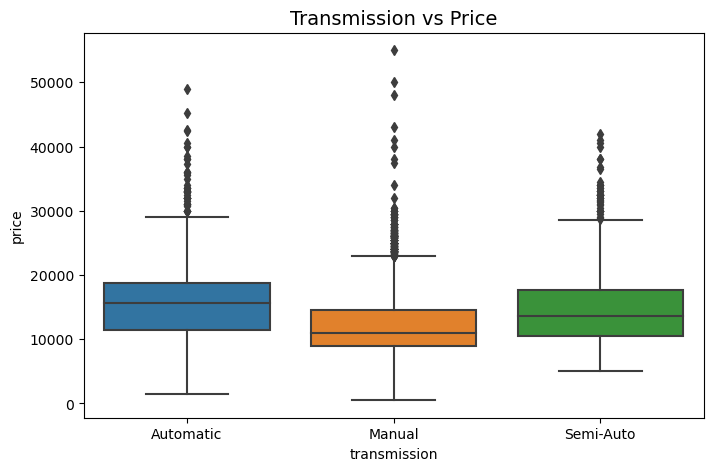

In [11]:
# Transmission Type vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='transmission', y='price', data=df)
plt.title("Transmission vs Price", fontsize=14)
plt.show()

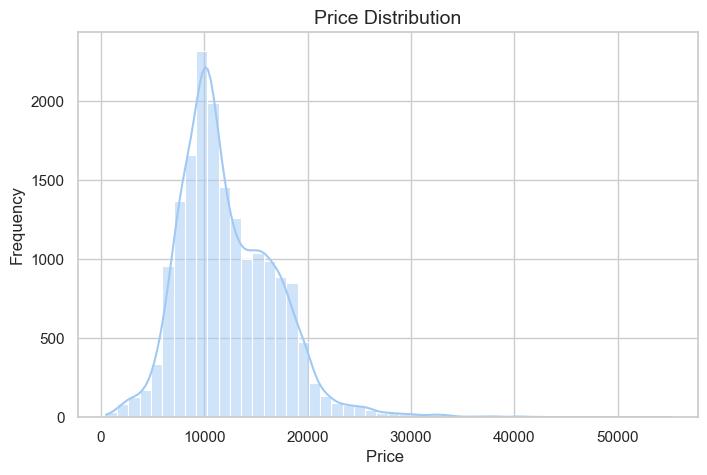

In [12]:
# Price Distribution
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution", fontsize=14)
plt.xlabel("Price ")
plt.ylabel("Frequency")
plt.show()

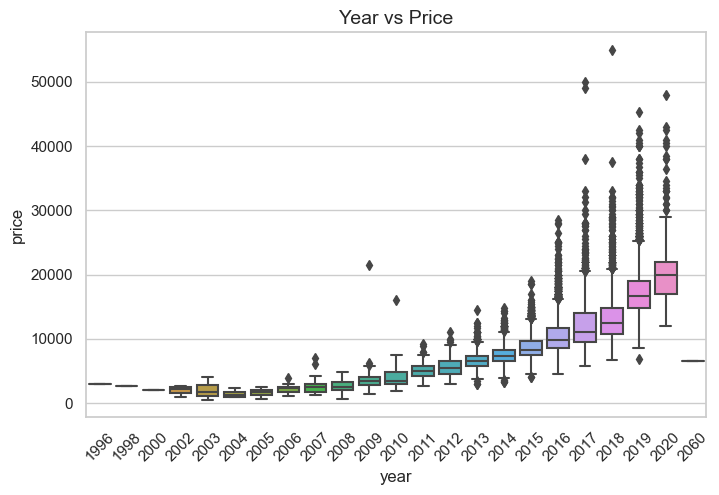

In [13]:
# Year vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='year', y='price', data=df)
plt.xticks(rotation=45)
plt.title("Year vs Price", fontsize=14)
plt.show()

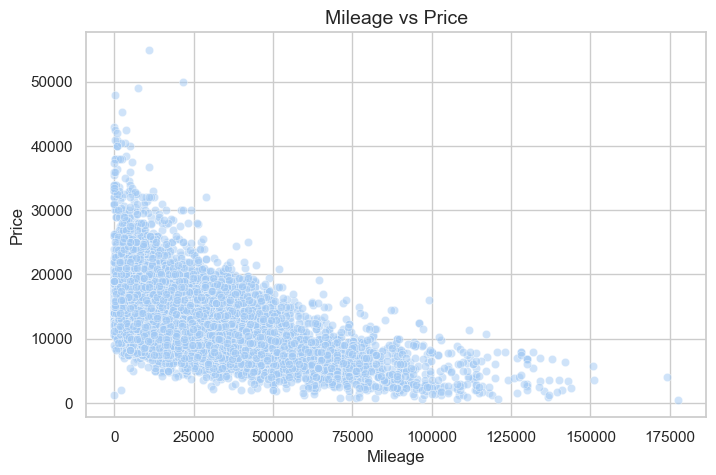

In [14]:
# Mileage vs Price
plt.figure(figsize=(8,5))
sns.scatterplot(x='mileage', y='price', data=df, alpha=0.5)
plt.title("Mileage vs Price", fontsize=14)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.show()

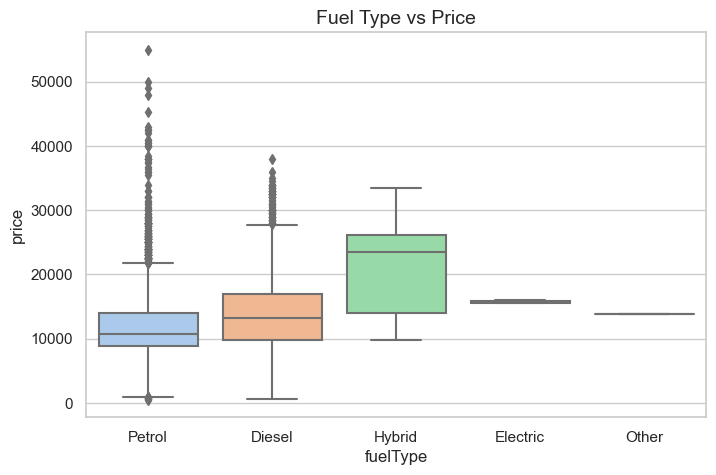

In [15]:
# Fuel Type vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='fuelType', y='price', data=df)
plt.title("Fuel Type vs Price", fontsize=14)
plt.show()

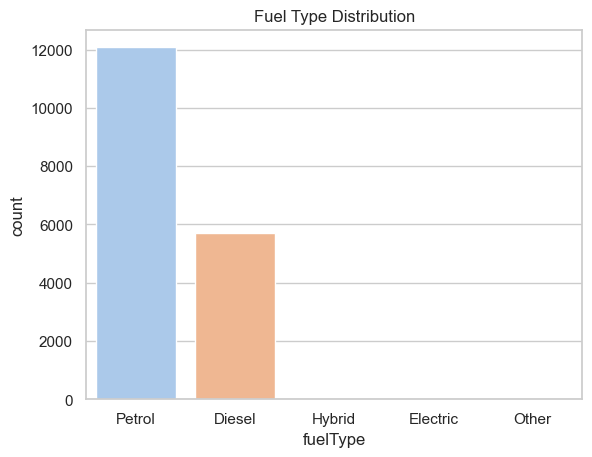

In [16]:
# Fuel type distribution
sns.countplot(x='fuelType', data=df)
plt.title("Fuel Type Distribution")
plt.show()

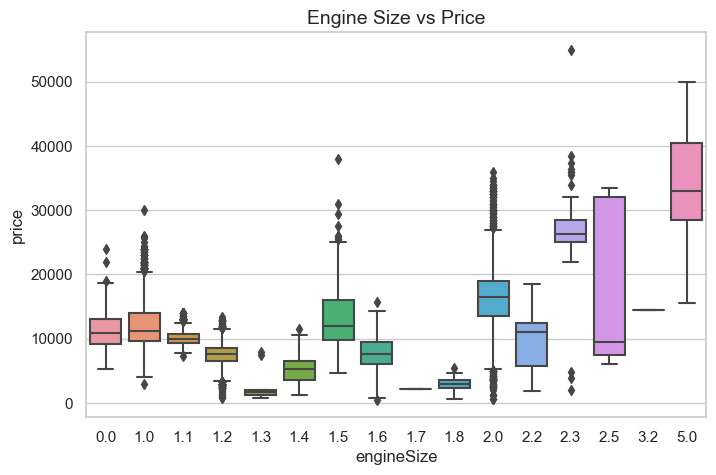

In [17]:
# Engine Size vs Price
plt.figure(figsize=(8,5))
sns.boxplot(x='engineSize', y='price', data=df)
plt.title("Engine Size vs Price", fontsize=14)
plt.show()

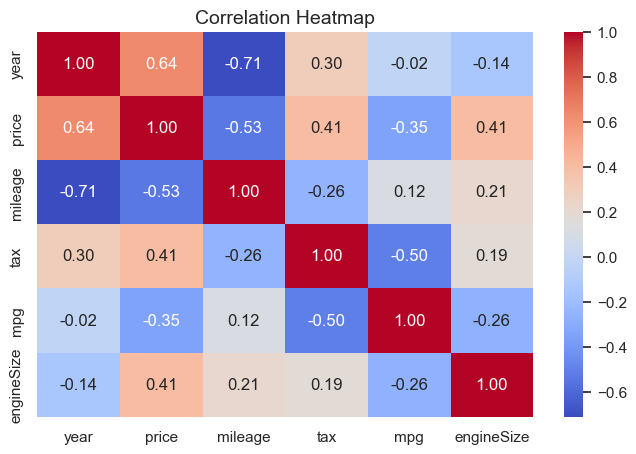

In [18]:
# Correlation Heatmap (numeric features)
plt.figure(figsize=(8,5))
corr = df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

### 5) Train/Test Split & Feature Types

In [19]:
target = "price"
X = df.drop(columns=[target])
y = df[target].astype(float)

cat_cols = ["model", "transmission", "fuelType"]
num_cols = [c for c in X.columns if c not in cat_cols]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=None
)

X_train.shape, X_test.shape


((14249, 8), (3563, 8))

### 6) Preprocessing

In [21]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop"
)


### 7) Baseline: Linear Regression

In [22]:
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

baseline.fit(X_train, y_train)
pred_bl = baseline.predict(X_test)

In [23]:
r2_bl = r2_score(y_test, pred_bl)

# Safe RMSE calculation for all sklearn versions
rmse_bl = mean_squared_error(y_test, pred_bl) ** 0.5  

mae_bl = mean_absolute_error(y_test, pred_bl)
mape_bl = (np.abs(y_test - pred_bl) / np.maximum(y_test, 1)).mean() * 100

print(f"Baseline Linear Regression → R²: {r2_bl:.3f} | RMSE: {rmse_bl:,.2f} | MAE: {mae_bl:,.2f} | MAPE: {mape_bl:.2f}%")


Baseline Linear Regression → R²: 0.819 | RMSE: 2,015.19 | MAE: 1,360.54 | MAPE: 13.33%


####  Actual vs Predicted Prices

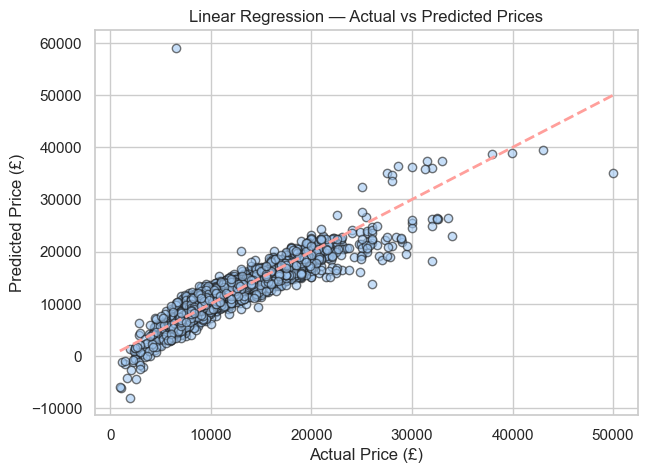

In [24]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, pred_bl, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Linear Regression — Actual vs Predicted Prices")
plt.show()

### 8) Main Model: Random Forest (+ quick tuning)

In [25]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_dist = {
    "model__n_estimators": [150, 200, 300, 400, 500],
    "model__max_depth": [None, 10, 12, 15, 18, 25],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", 0.5]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="r2",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
search.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'model__n_estimators': 200,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'sqrt',
 'model__max_depth': 18}

In [26]:
best_rf = search.best_estimator_
pred = best_rf.predict(X_test)

r2 = r2_score(y_test, pred)

rmse = mean_squared_error(y_test, pred) ** 0.5  

mae = mean_absolute_error(y_test, pred)
mape = (np.abs(y_test - pred) / np.maximum(y_test, 1)).mean() * 100

print(f"Random Forest (tuned) → R²: {r2:.3f} | RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:.2f}%")



Random Forest (tuned) → R²: 0.937 | RMSE: 1,186.02 | MAE: 818.89 | MAPE: 7.12%


### 8.1) Cross-Validation on Train

In [27]:
cv_scores = cross_val_score(best_rf, X_train, y_train, scoring="r2", cv=5, n_jobs=-1)
print("CV R² scores:", np.round(cv_scores, 3))
print("CV R² mean ± std:", cv_scores.mean().round(3), "±", cv_scores.std().round(3))


CV R² scores: [0.932 0.936 0.933 0.935 0.94 ]
CV R² mean ± std: 0.935 ± 0.003


## 9) Error Analysis (Residuals & Distribution)

Residual mean (should be ~0): -18.92


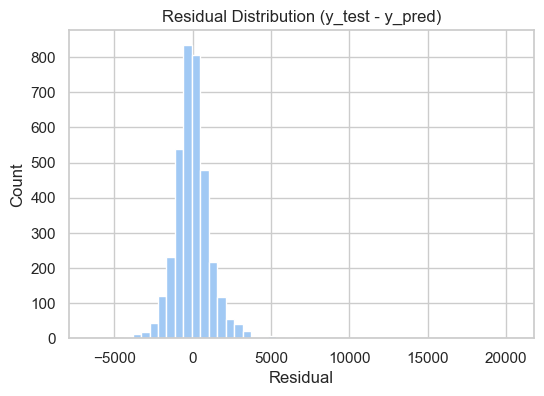

In [28]:
residuals = y_test - pred
print("Residual mean (should be ~0):", residuals.mean().round(2))

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (y_test - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


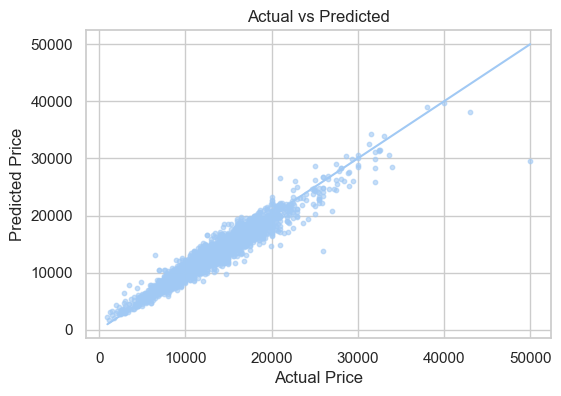

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, pred, s=10, alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()


### 10) Feature Importance (Permutation)

In [30]:
from sklearn.inspection import permutation_importance

# Transform X_test using the preprocessor
X_test_trans = best_rf.named_steps["prep"].transform(X_test)

# Get the fitted model only (not the whole pipeline)
model_only = best_rf.named_steps["model"]

# Get feature names from the preprocessor
fitted_prep = best_rf.named_steps["prep"].fit(X_train, y_train)
ohe = fitted_prep.named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols)
num_names = num_cols
feature_names = list(cat_names) + num_names

# Run permutation importance on the transformed data
perm = permutation_importance(
    model_only, X_test_trans, y_test,
    scoring="r2", n_repeats=5, random_state=42, n_jobs=1
)

# Build DataFrame
importances = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

# Show top 15
print(importances.head(15))


                feature  importance
32                 year    0.275257
36           engineSize    0.190368
33              mileage    0.126520
35                  mpg    0.077586
34                  tax    0.044878
5         model_ Fiesta    0.035022
13          model_ Kuga    0.029653
12           model_ Ka+    0.013389
31      fuelType_Petrol    0.012324
6          model_ Focus    0.011541
3           model_ Edge    0.010955
27      fuelType_Diesel    0.008318
15       model_ Mustang    0.007093
25  transmission_Manual    0.006168
18         model_ S-MAX    0.003813


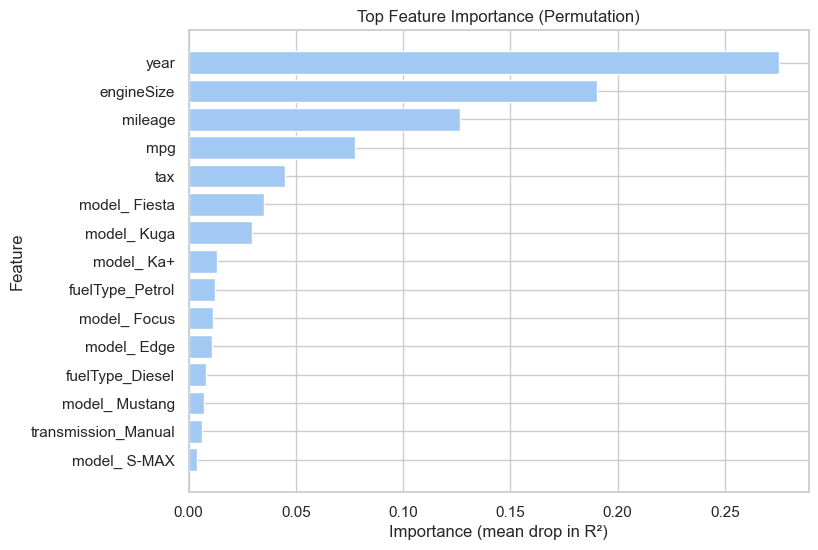

In [31]:
plt.figure(figsize=(8,6))
top = importances.head(15).sort_values("importance")
plt.barh(top["feature"], top["importance"])
plt.title("Top Feature Importance (Permutation)")
plt.xlabel("Importance (mean drop in R²)")
plt.ylabel("Feature")
plt.show()


### 11) Example Prediction

In [32]:
example = pd.DataFrame({
    "model": ["Fiesta"],
    "year": [2019],
    "transmission": ["Manual"],
    "mileage": [15000],
    "fuelType": ["Petrol"],
    "tax": [145],
    "mpg": [48.7],
    "engineSize": [1.0]
})

example_price = best_rf.predict(example)[0]
print(f"Predicted Price for {example.iloc[0].to_dict()}: {example_price:,.2f}")


Predicted Price for {'model': 'Fiesta', 'year': 2019, 'transmission': 'Manual', 'mileage': 15000, 'fuelType': 'Petrol', 'tax': 145, 'mpg': 48.7, 'engineSize': 1.0}: 14,623.92


### 12) Conclusions

- **Baseline (Linear Regression)**:  
  - R² = **0.819** → Explains about 81.9% of the variance in car prices.  
  - RMSE ≈ **2,015** → Predictions are off by 2,015 on average.  
  - MAPE ≈ **13.33%** → On average, predictions are 13% away from actual prices.  

- **Random Forest (Tuned)**:  
  - R² = **0.937** → Explains 93.7% of price variance.  
  - RMSE ≈ **1,186** → Predictions are off by 1,186 on average.  
  - MAPE ≈ **7.12%** → Average percentage error is just 7%.  
  - CV R² mean ± std = **0.935 ± 0.003** → Consistent performance across cross-validation folds.  
  - Residual mean ≈ **-18.92** → Very close to zero, indicating no major systematic bias.

#### Model Verdict:
- The **Random Forest model** significantly outperforms the baseline Linear Regression model.  
- Low RMSE and MAPE values show that the predictions are **accurate and reliable** for most practical pricing scenarios.  
- Cross-validation confirms the model is **stable** and not overfitting.  
- The example prediction of **14,623.92** for the test case is within a realistic range based on the dataset distribution.

#### Next Steps:
- Explore Gradient Boosting (XGBoost) to see if further improvement is possible.
- Apply log transformation to the target variable to reduce the effect of outliers.
- Investigate the most important features to provide insights into pricing trends.


### 13) Save Model for Reuse

In [33]:
import joblib
joblib.dump(best_rf, "ford_price_model_rf.joblib")
print("Saved: ford_price_model_rf.joblib")


Saved: ford_price_model_rf.joblib
